# Training denoiser for PnP

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#CT Radon transform forward model and denoising functions
from skimage.transform import radon, resize, iradon
from skimage.data import shepp_logan_phantom


#Torch imports
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms


# Deep inverse imports
import deepinv as dinv
from deepinv.models import DnCNN, DRUNet

#TV and BM3D imports with tracker
from tqdm import tqdm
from bm3d import bm3d
from utils.torch_denoise_tv_chambolle import *

#Reproducible results
torch.manual_seed(42)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
transform = transforms.Compose([transforms.ToTensor()])

#adding noise to images
def add_noise(img, sigma=0.5):
    """ 
    Adds Gaussian noise - image denoising problem
    """
    noise = sigma * torch.randn_like(img)
    return img + noise



# Load the training data (first of one natural image then 7 different natural images) and Trainer function construct

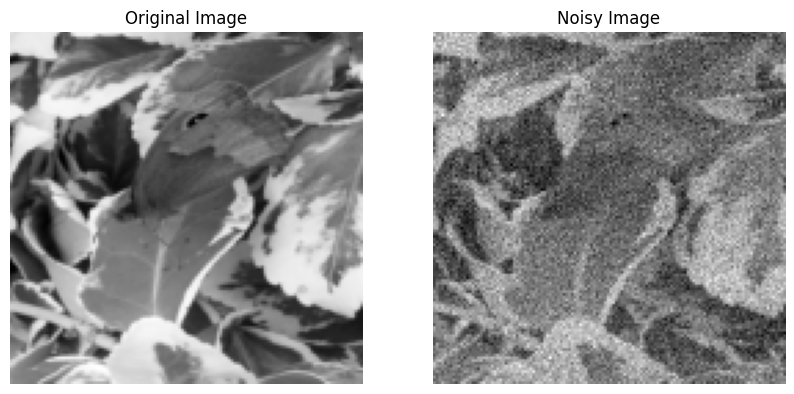

In [ ]:
#Natural images # example of a butterfly image
from PIL import Image
path = "Natural_Images/butterfly.png"
image = Image.open(path)
dim = 128
transform = transforms.Compose([transforms.Resize((dim, dim)),
                                transforms.Grayscale(num_output_channels=1),
                                 transforms.ToTensor(),])
img = transform(image)
img = img.squeeze(0)  # Add batch dimension
noisy  = add_noise(img, sigma=0.1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  
plt.imshow(img.squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(noisy.squeeze(), cmap='gray')
plt.title('Noisy Image')
plt.axis('off')
plt.show()

In [109]:
# Loading of 7 different natural images
#image paths
path1 = "Natural_Images/butterfly.png"
path2 = "Natural_Images/boat.png"
path3 = "Natural_Images/house.png"
path4 = "Natural_Images/peppers256.png"
path5 = "Natural_Images/hill.png"
path6 = "Natural_Images/house.png"
path7 = "Natural_Images/man.png"

paths = [path1, path2, path3, path4, path5, path6, path7]
# Load and preprocess images
def load_and_preprocess_images(paths):
    images = []
    for path in paths:
        img = Image.open(path).convert('L')  # Convert to grayscale
        img = transform(img)  # Apply the transform
        images.append(img.squeeze(0))  # Remove the batch dimension
    return images

images = load_and_preprocess_images(paths) # 7 Natural Images loaded 

In [ ]:
#Trainer function for the denoiser
def Trainer(loader, denoiser, epochs=50, lr=1e-3):
    """ 
    Normal PnP training which is used to remove Gaussian noise from images 
    Args:
        loader (DataLoader): DataLoader for training data
        denoiser (nn.Module): Denoising model
        epochs (int): Number of training epochs
        lr (float): Learning rate for the optimiser
    """
    optimiser = optim.Adam(denoiser.parameters(), lr=lr)
    criterion = nn.MSELoss()
    training_loss = []
    for epoch in range(epochs):
        denoiser.train()
        running_loss = 0.0
        for noisy, clean in tqdm(loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            noisy, clean = noisy.to(device), clean.to(device)
            optimiser.zero_grad()
            output = denoiser(noisy)
            loss = criterion(output, clean)
            loss.backward()
            optimiser.step()
            running_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(loader):2f}")
        training_loss.append(running_loss / len(loader))
    return training_loss



# Creation of the training dataset (clean and noisy images)

In [125]:
class NoisyImageDataset(Dataset):
    def __init__(self, clean_images, sigma=0.05):
        self.clean = clean_images
        self.noisy = [img + sigma * torch.randn_like(img) for img in clean_images]

    def __len__(self):
        return len(self.clean)

    def __getitem__(self, idx):
        clean = self.clean[idx].unsqueeze(0)  # [1, H, W]
        noisy = self.noisy[idx].unsqueeze(0)
        return noisy, clean
    
def plot_loss(losses, title='MSE Training Loss', label='PnP Loss'):
    """ 
    Plots the training loss over epochs
    Args:
        losses (list): List of loss values per epoch
        title (str): Title of the plot
    """
    plt.figure(figsize=(10, 5))
    for i, loss in enumerate(losses):
        plt.semilogy(loss, label=label[i] if isinstance(label, list) else label, marker='o')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [116]:

# Dataset with clean and noisy images

###Butterfly dataset of 1024 images
# Create a dataset of noisy images
num_images = 1024  # Number of images to generate
noise_level = 0.1  # Standard deviation of Gaussian noise
train_imgs = [img for _ in range(num_images)]
train_imgs = [img.clamp(0, 1).to(device).float() for img in train_imgs]
dataset = NoisyImageDataset(train_imgs, sigma=noise_level)
loader = DataLoader(dataset, batch_size=1, shuffle=True)


### 7 Natural images dataset
# Create a dataset of noisy images
nat_train_imgs = images  # Use the loaded natural images
repeat_times = 147  # 7 * 147 = 1029
nat_train_imgs = nat_train_imgs * repeat_times
nat_train_imgs = nat_train_imgs[:num_images]  # Trim to match num_images if needed
nat_train_imgs = [img.clamp(0, 1).to(device).float() for img in nat_train_imgs]
nat_dataset = NoisyImageDataset(nat_train_imgs, sigma=noise_level)
nat_loader = DataLoader(nat_dataset, batch_size=1, shuffle=True)


# Two denoisers (2 Convolutional layers and a 3 convolution layer one)

In [120]:
# Simple denoiser example
class SimpleDenoiser(nn.Module):
    """
    A simple denoising network using Conv2D layers
    Architecture:
        Conv2D -> ReLU -> Conv2D
    """
    def __init__(self, channels=1, features=32, kernel_size=5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.net(x)
    

# Improved denoiser
class ImprovedDenoiser(nn.Module):
    """
    A more complex denoising network using Conv2D layers
    Architecture:
        Conv2D -> ReLU -> Conv2D -> ReLU -> Conv2D
    """
    def __init__(self, channels=1, features=32, kernel_size=5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, features, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(features, features, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(features, channels, kernel_size=kernel_size, padding=kernel_size//2)
        )

    def forward(self, x):
        return self.net(x)

# Denoiser training and performance

In [121]:
#On just the butterfly image dataset
simple_denoiser = SimpleDenoiser().to(device)
denoiser_loss = Trainer(loader, simple_denoiser, epochs=10, lr=1e-3)
simple_denoiser.eval()

Epoch 1/10: 100%|██████████| 1024/1024 [00:09<00:00, 106.35it/s]


Epoch 1, Loss: 0.003533


Epoch 2/10: 100%|██████████| 1024/1024 [00:10<00:00, 99.12it/s]


Epoch 2, Loss: 0.002047


Epoch 3/10: 100%|██████████| 1024/1024 [00:10<00:00, 96.47it/s] 


Epoch 3, Loss: 0.001996


Epoch 4/10: 100%|██████████| 1024/1024 [00:08<00:00, 118.51it/s]


Epoch 4, Loss: 0.001978


Epoch 5/10: 100%|██████████| 1024/1024 [00:11<00:00, 91.55it/s] 


Epoch 5, Loss: 0.001970


Epoch 6/10: 100%|██████████| 1024/1024 [00:08<00:00, 123.28it/s]


Epoch 6, Loss: 0.001965


Epoch 7/10: 100%|██████████| 1024/1024 [00:09<00:00, 112.80it/s]


Epoch 7, Loss: 0.001962


Epoch 8/10: 100%|██████████| 1024/1024 [00:09<00:00, 113.41it/s]


Epoch 8, Loss: 0.001951


Epoch 9/10: 100%|██████████| 1024/1024 [00:11<00:00, 92.11it/s]


Epoch 9, Loss: 0.001946


Epoch 10/10: 100%|██████████| 1024/1024 [00:09<00:00, 110.26it/s]

Epoch 10, Loss: 0.001939


SimpleDenoiser(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:
improved_denoiser = ImprovedDenoiser().to(device)
improved_loss = Trainer(loader, improved_denoiser, epochs=10, lr=1e-3)
improved_denoiser.eval()

Epoch 1/10: 100%|██████████| 1024/1024 [00:34<00:00, 29.57it/s]


Epoch 1, Loss: 0.003440


Epoch 2/10: 100%|██████████| 1024/1024 [00:51<00:00, 19.78it/s]


Epoch 2, Loss: 0.001948


Epoch 3/10: 100%|██████████| 1024/1024 [01:29<00:00, 11.44it/s]


Epoch 3, Loss: 0.001868


Epoch 4/10: 100%|██████████| 1024/1024 [00:37<00:00, 27.15it/s]


Epoch 4, Loss: 0.001811


Epoch 5/10: 100%|██████████| 1024/1024 [00:36<00:00, 27.69it/s]


Epoch 5, Loss: 0.001754


Epoch 6/10: 100%|██████████| 1024/1024 [00:41<00:00, 24.74it/s]


Epoch 6, Loss: 0.001704


Epoch 7/10: 100%|██████████| 1024/1024 [00:56<00:00, 18.22it/s]


Epoch 7, Loss: 0.001662


Epoch 8/10: 100%|██████████| 1024/1024 [00:42<00:00, 24.00it/s]


Epoch 8, Loss: 0.001628


Epoch 9/10: 100%|██████████| 1024/1024 [00:40<00:00, 24.99it/s]


Epoch 9, Loss: 0.001595


Epoch 10/10: 100%|██████████| 1024/1024 [00:38<00:00, 26.63it/s]

Epoch 10, Loss: 0.001571


ImprovedDenoiser(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

## Natural image dataset (7 kinds taken from Natural_Images)

In [ ]:
nat_simple_denoiser = SimpleDenoiser().to(device)
nat_denoiser_loss = Trainer(nat_loader, nat_simple_denoiser, epochs=10, lr=1e-3)
nat_simple_denoiser.eval()

Epoch 1/10: 100%|██████████| 1024/1024 [00:04<00:00, 212.91it/s]


Epoch 1, Loss: 0.004302


Epoch 2/10: 100%|██████████| 1024/1024 [00:04<00:00, 210.34it/s]


Epoch 2, Loss: 0.001810


Epoch 3/10: 100%|██████████| 1024/1024 [00:05<00:00, 190.87it/s]


Epoch 3, Loss: 0.001697


Epoch 4/10: 100%|██████████| 1024/1024 [00:06<00:00, 159.94it/s]


Epoch 4, Loss: 0.001657


Epoch 5/10: 100%|██████████| 1024/1024 [00:06<00:00, 159.84it/s]


Epoch 5, Loss: 0.001633


Epoch 6/10: 100%|██████████| 1024/1024 [00:07<00:00, 136.87it/s]


Epoch 6, Loss: 0.001620


Epoch 7/10: 100%|██████████| 1024/1024 [00:07<00:00, 137.86it/s]


Epoch 7, Loss: 0.001607


Epoch 8/10: 100%|██████████| 1024/1024 [00:07<00:00, 144.54it/s]


Epoch 8, Loss: 0.001602


Epoch 9/10: 100%|██████████| 1024/1024 [00:07<00:00, 135.29it/s]


Epoch 9, Loss: 0.001597


Epoch 10/10: 100%|██████████| 1024/1024 [00:07<00:00, 129.60it/s]

Epoch 10, Loss: 0.001590


SimpleDenoiser(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [122]:
nat_improved_denoiser = ImprovedDenoiser().to(device)
nat_improved_loss = Trainer(nat_loader, nat_improved_denoiser, epochs=10, lr=1e-3)
nat_improved_denoiser.eval()

Epoch 1/10: 100%|██████████| 1024/1024 [00:50<00:00, 20.16it/s]


Epoch 1, Loss: 0.002845


Epoch 2/10: 100%|██████████| 1024/1024 [00:48<00:00, 20.94it/s]


Epoch 2, Loss: 0.001570


Epoch 3/10: 100%|██████████| 1024/1024 [00:49<00:00, 20.73it/s]


Epoch 3, Loss: 0.001507


Epoch 4/10: 100%|██████████| 1024/1024 [00:50<00:00, 20.40it/s]


Epoch 4, Loss: 0.001473


Epoch 5/10: 100%|██████████| 1024/1024 [00:49<00:00, 20.54it/s]


Epoch 5, Loss: 0.001443


Epoch 6/10: 100%|██████████| 1024/1024 [00:46<00:00, 21.83it/s]


Epoch 6, Loss: 0.001407


Epoch 7/10: 100%|██████████| 1024/1024 [00:48<00:00, 20.90it/s]


Epoch 7, Loss: 0.001386


Epoch 8/10: 100%|██████████| 1024/1024 [00:46<00:00, 22.23it/s]


Epoch 8, Loss: 0.001376


Epoch 9/10: 100%|██████████| 1024/1024 [00:50<00:00, 20.25it/s]


Epoch 9, Loss: 0.001347


Epoch 10/10: 100%|██████████| 1024/1024 [00:50<00:00, 20.33it/s]

Epoch 10, Loss: 0.001344


ImprovedDenoiser(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

Once trained the denoisers, can save the weights as follows:

In [ ]:
# To save the denoisers and weights
torch.save(simple_denoiser.state_dict(), 'saved_models/simple_denoiser.pth')
torch.save(improved_denoiser.state_dict(), 'saved_models/improved_denoiser.pth')
torch.save(nat_simple_denoiser.state_dict(), 'saved_models/nat_simple_denoiser.pth')
torch.save(nat_improved_denoiser.state_dict(), 'saved_models/nat_improved_denoiser.pth')

#To load the denoisers and weights - for later use
simple_denoiser = SimpleDenoiser().to(device)
simple_denoiser.load_state_dict(torch.load('saved_models/simple_denoiser.pth'))
improved_denoiser = ImprovedDenoiser().to(device)
improved_denoiser.load_state_dict(torch.load('saved_models/improved_denoiser.pth'))

<All keys matched successfully>

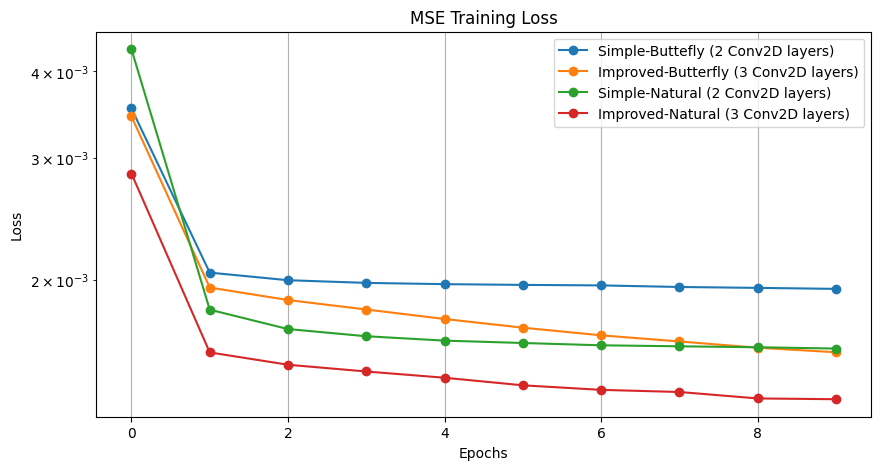

In [126]:
losses = [denoiser_loss, improved_loss, nat_denoiser_loss, nat_improved_loss]
labels = ['Simple-Buttefly (2 Conv2D layers)', 'Improved-Butterfly (3 Conv2D layers)', 'Simple-Natural (2 Conv2D layers)', 'Improved-Natural (3 Conv2D layers)']
plot_loss(losses, label=labels)

# Test on images

In [163]:
# Test results on a new image
test_noise_level = 0.08  # Standard deviation of Gaussian noise
test_image_path = "Natural_Images/house.png"
test_image = Image.open(test_image_path)
test_image = transform(test_image)
test_noisy = add_noise(test_image, sigma=test_noise_level)

def plot_results(ground_truth, test_noisy, denoised_list, titles):
    """
    Plots the noisy and denoised images with a global colorbar at the bottom.

    Args:
        ground_truth (Tensor): Ground truth image tensor.
        test_noisy (Tensor): Noisy image tensor.
        denoised_list (list): List of denoised image tensors.
        titles (list): List of titles for each subplot.
    """
    n_imgs = len(denoised_list) + 2
    fig, axes = plt.subplots(1, n_imgs, figsize=(4 * n_imgs, 5))
    #vmin = min(ground_truth.min().item(), test_noisy.min().item(), *(d.min().item() for d in denoised_list))
    #vmax = max(ground_truth.max().item(), test_noisy.max().item(), *(d.max().item() for d in denoised_list))
    vmin = 0
    vmax = 1

    imgs = []
    imgs.append(axes[0].imshow(ground_truth.squeeze(), cmap='gray', vmin=vmin, vmax=vmax))
    axes[0].set_title('Ground Truth Image')
    axes[0].axis('off')

    imgs.append(axes[1].imshow(test_noisy.squeeze(0), cmap='gray', vmin=vmin, vmax=vmax))
    axes[1].set_title('Noisy Image')
    axes[1].axis('off')

    for i, denoised in enumerate(denoised_list):
        imgs.append(axes[i + 2].imshow(denoised.squeeze(0).detach().cpu().numpy(), cmap='gray', vmin=vmin, vmax=vmax))
        axes[i + 2].set_title(titles[i])
        axes[i + 2].axis('off')

    # Add a single colorbar at the bottom
    cbar = fig.colorbar(imgs[0], ax=axes, orientation='horizontal', fraction=0.15, pad=0.12)
    cbar.set_label('Pixel Intensity')
    plt.show()

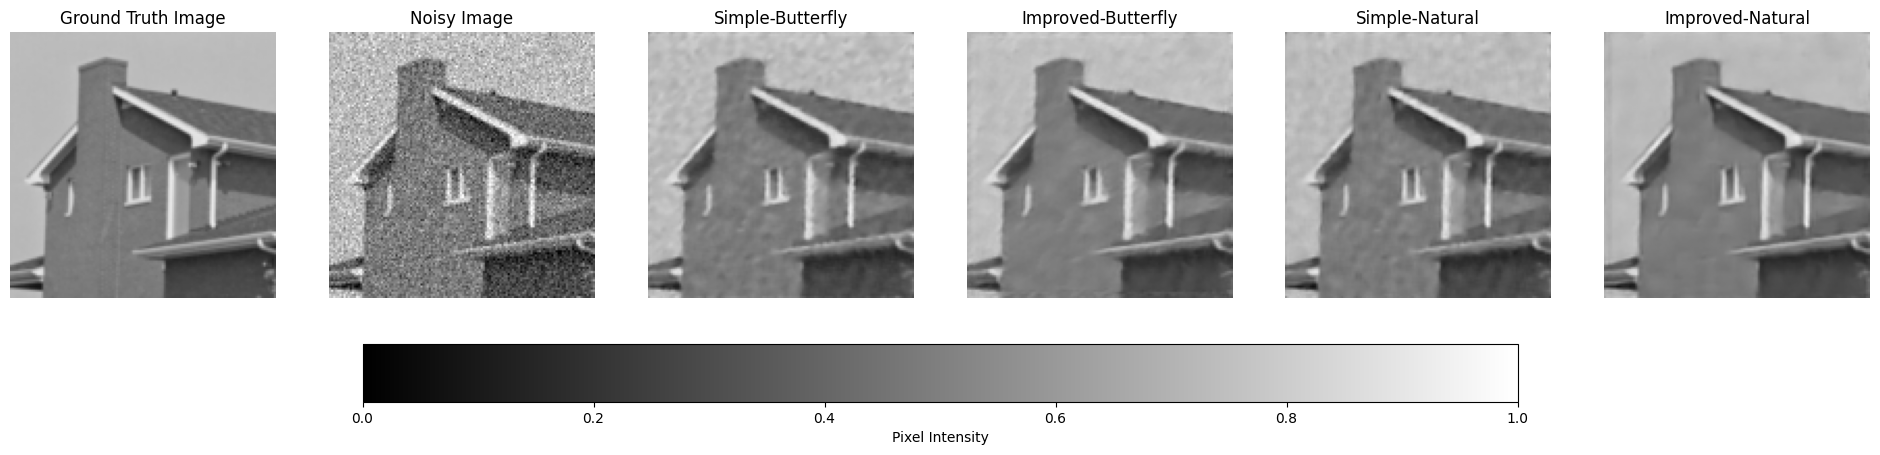

In [ ]:
#Apply the denoisers to the test noisy image
simple_denoised = simple_denoiser(test_noisy)  
improved_denoised = improved_denoiser(test_noisy)  
nat_simple_denoised = nat_simple_denoiser(test_noisy)  
nat_improved_denoised = nat_imporved_denoiser(test_noisy)  

plot_results(test_image, test_noisy, 
             [simple_denoised, improved_denoised, nat_simple_denoised, nat_improved_denoised], 
             ['Simple-Butterfly', 'Improved-Butterfly', 'Simple-Natural', 'Improved-Natural'])


  